In [37]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
from tensorflow.python.client import device_lib

%matplotlib inline

In [24]:
local_device_protos = device_lib.list_local_devices()
[x.name for x in local_device_protos if x.device_type == 'GPU']

['/gpu:0']

In [11]:
path_to_data="../../data/text8/text8"

with open(path_to_data) as f:
    words = tf.compat.as_str(f.read()).split()

In [12]:
print('Data size', len(words))

Data size 17005207


In [14]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()

    for word, _ in count:
        dictionary[word] = len(dictionary)
  
    data = list()
    unk_count = 0
  
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    
    return data, count, dictionary, reverse_dictionary

In [15]:
data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5237, 3082, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [16]:
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
  
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
  
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
    
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
           
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
            
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    return batch, labels

In [17]:
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3082 originated -> 12 as
3082 originated -> 5237 anarchism
12 as -> 6 a
12 as -> 3082 originated
6 a -> 12 as
6 a -> 195 term
195 term -> 6 a
195 term -> 2 of


In [18]:
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

In [19]:
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

In [20]:
graph = tf.Graph()

In [39]:
with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

        # Compute the average NCE loss for the batch.
        # tf.nce_loss automatically draws a new sample of the negative labels each
        # time we evaluate the loss.
    loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                         biases=nce_biases,
                         labels=train_labels,
                         inputs=embed,
                         num_sampled=num_sampled,
                         num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.initialize_all_variables()

In [40]:
# Step 5: Begin training.
num_steps = 100001

In [41]:
with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = "Nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
                
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  289.693267822
Nearest to or: backdrop, patagonian, hyderabad, farmers, powers, jamison, mcpherson, overridden,
Nearest to three: agility, norman, trigger, stirling, yan, leno, sennett, evangelista,
Nearest to its: swiftly, fyrom, ferrol, hz, fireworks, verse, guantanamo, brentano,
Nearest to during: rojas, called, lex, lasts, sunk, procession, episodes, peek,
Nearest to not: decomposers, rays, thom, aquaculture, capricornus, zr, exposes, kabul,
Nearest to state: budapest, advancement, cathal, newington, accumulator, kayaks, auditory, malicious,
Nearest to six: rehearsed, alene, barnett, commando, ning, protectionist, propel, craton,
Nearest to at: toby, besieging, ascendant, flavian, suras, mausoleum, ascetical, buggy,
Nearest to some: leyte, gormenghast, trench, bracelet, ignored, howl, safeguard, atp,
Nearest to than: ezquerra, retake, regicide, implicit, lepton, egress, youngsters, topology,
Nearest to known: villages, compressing, stings, mulh

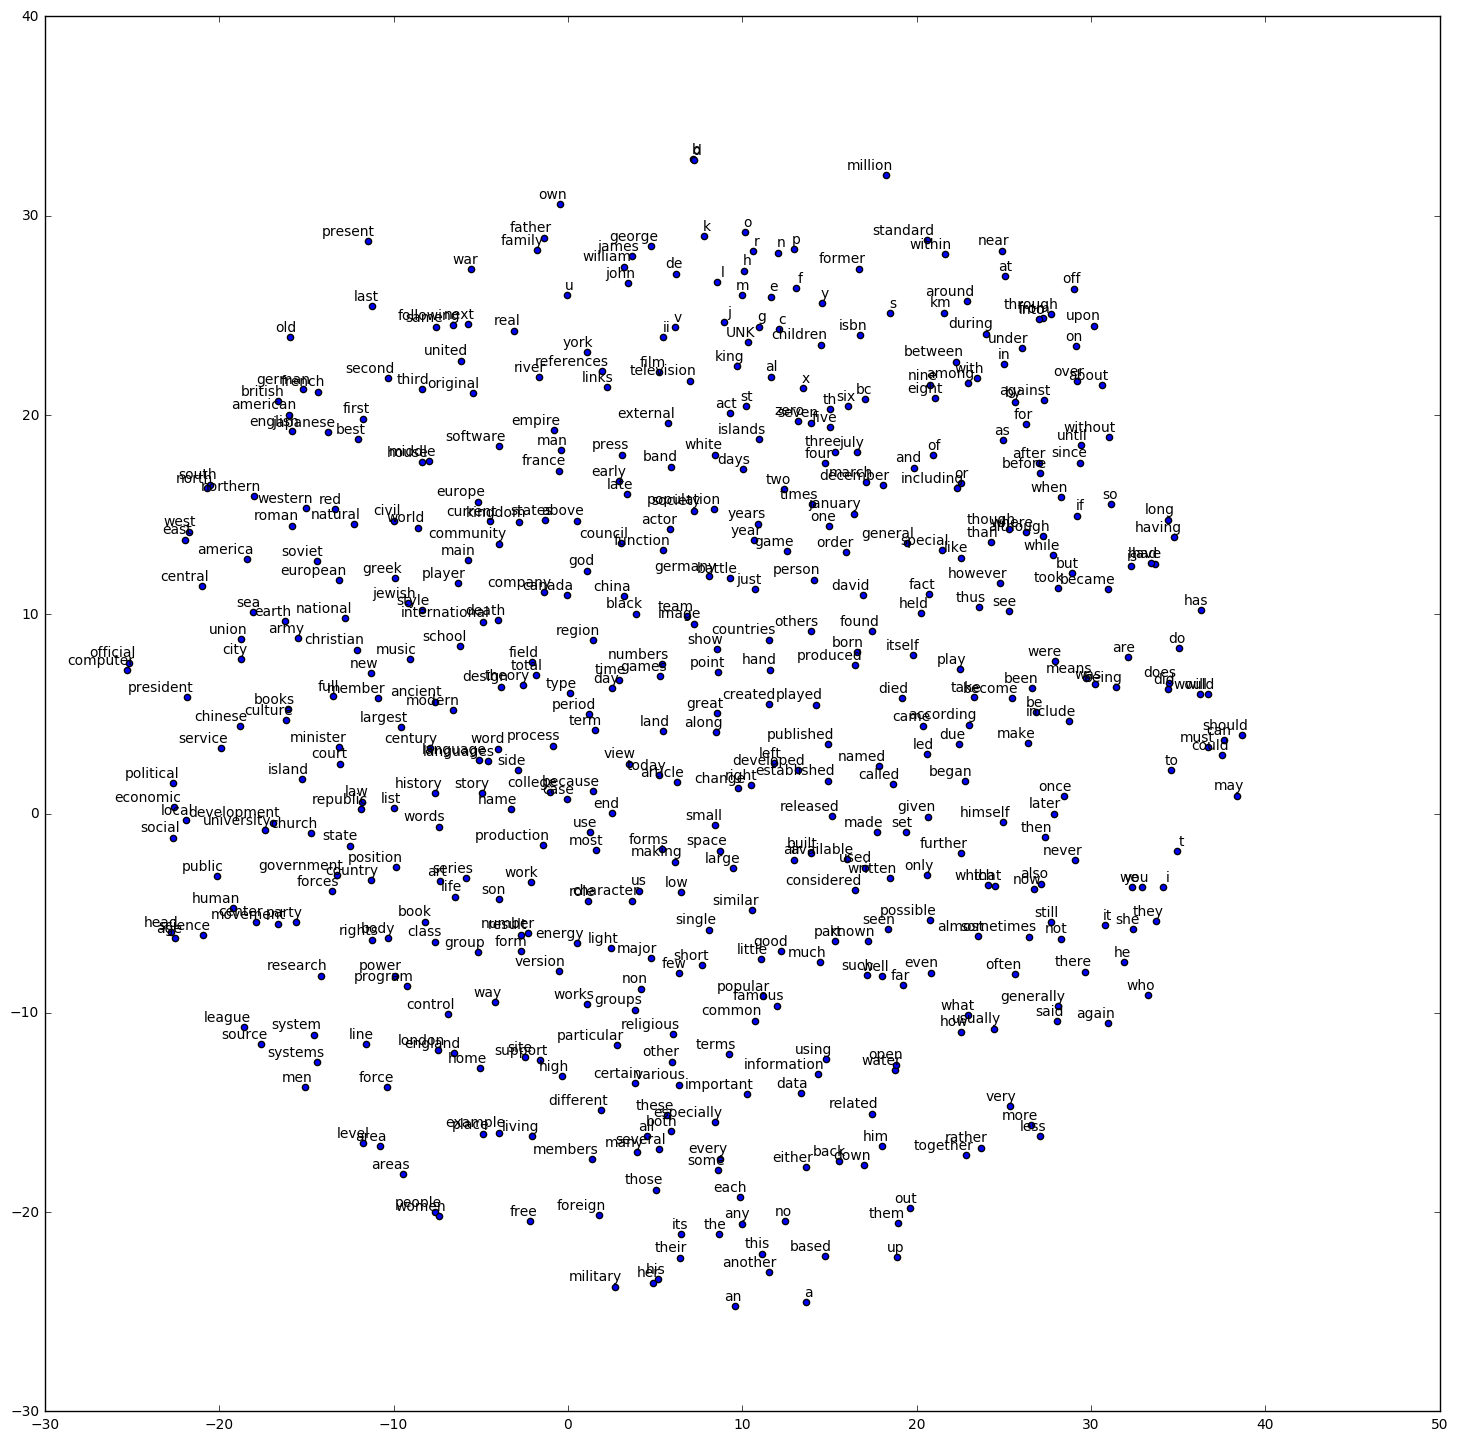

In [42]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

    
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels)    